In [1]:
import gym
import gym_bandits
import numpy as np
from tqdm import tqdm

from itertools import cycle

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

np.set_printoptions(suppress=True)

Let's go over the exploration strategies that will be contending this time

In [2]:
def e_greedy_decay_strategy(env, initial_epsilon=1.0, decay_rate=1e-4, min_epsilon=0.0, n_trials=10000):
    Q = np.zeros((env.action_space.n))
    N = np.zeros((env.action_space.n))

    returns = np.empty(n_trials)
    for t in range(n_trials):
        epsilon = max(initial_epsilon * np.exp(-decay_rate * t), min_epsilon)
        action = np.argmax(Q) if np.random.random() > epsilon else env.action_space.sample()
        _, reward, _, _ = env.step(action)
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/N[action]
        
        returns[t] = reward
    return np.cumsum(returns)/(np.arange(n_trials)+1)

In [3]:
def softmax(env, initial_temp=1.0, decay_rate=1e-3, min_temp=1e-2, n_trials=10000):
    Q = np.zeros((env.action_space.n))
    N = np.zeros((env.action_space.n))

    returns = np.empty(n_trials)
    for t in range(n_trials):
        temp = max(initial_temp * np.exp(-decay_rate * t), min_temp)
        probs = np.exp(Q/temp) / np.sum(np.exp(Q/temp))
        action = np.random.choice(np.arange(len(Q)), size=1, p=probs)[0]
        _, reward, _, _ = env.step(action)
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/N[action]
        
        returns[t] = reward
    return np.cumsum(returns)/(np.arange(n_trials)+1)

In [4]:
def upper_confidence_bound(env, c=1, n_trials=10000):
    Q = np.zeros((env.action_space.n))
    N = np.zeros((env.action_space.n))

    returns = np.empty(n_trials)
    for t in range(n_trials):
        if t < len(Q):
            action = t
        else:
            U = c * np.sqrt(np.log(t)/N)
            action = np.argmax(Q + U)
        _, reward, _, _ = env.step(action)
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/N[action]
        
        returns[t] = reward
    return np.cumsum(returns)/(np.arange(n_trials)+1)

In [5]:
def bayesian(env, tau=1, n_trials=10000):
    R = np.zeros((env.action_space.n))
    N = np.zeros((env.action_space.n))
    means = np.zeros((env.action_space.n))
    
    returns = np.empty(n_trials)
    for t in range(n_trials):
        if t < len(N):
            action = t
        else:
            action = np.argmax(np.random.randn() / np.sqrt(N) + means)
        _, reward, _, _ = env.step(action)
        R[action] += reward
        N[action] += tau
        means[action] = tau * R[action] / N[action]

        returns[t] = reward
    return np.cumsum(returns)/(np.arange(n_trials)+1)

This function is the same we had in the previous Notebook. It just runs the experiments.

In [6]:
def run_exploration_strategies_experiment(env):
    ret_egd1, ret_ucb1, ret_ucb2 = [], [], []
    ret_sm1, ret_sm2 = [], []
    ret_b1, ret_b2 = [], []
    np.random.seed(12345)

    for i in tqdm(range(100)):
        env.reset()
        ret_egd1.append(e_greedy_decay_strategy(env, decay_rate=1e-2))
        ret_ucb1.append(upper_confidence_bound(env, c=0.5))
        ret_ucb2.append(upper_confidence_bound(env, c=2))
        ret_sm1.append(softmax(env, decay_rate=5e-1, min_temp=0.1))
        ret_sm2.append(softmax(env, decay_rate=1e-2, min_temp=0.01))
        ret_b1.append(bayesian(env, tau=1))
        ret_b2.append(bayesian(env, tau=10))
    return (np.array(ret_egd1), 'decay 1e-2 -> 0'), \
        (np.array(ret_ucb1), 'ucb 0.5'), (np.array(ret_ucb2), 'ucb 2.0'), \
        (np.array(ret_sm1), 'softmax 5e-1 -> 0.1'), (np.array(ret_sm2), 'softmax 1e-2 -> 0.01'), \
        (np.array(ret_b1), 'bayesian 1'), (np.array(ret_b2), 'bayesian 10')

We start by comparing the algorithms in the Bernoulli environment.

In [7]:
env = gym.make("BanditTwoArmedHighHighFixed-v0")
results = run_exploration_strategies_experiment(env)

100%|██████████| 100/100 [02:35<00:00,  1.55s/it]


We now plot the cummulative reward obtained by these strategies over 10,000 trials.

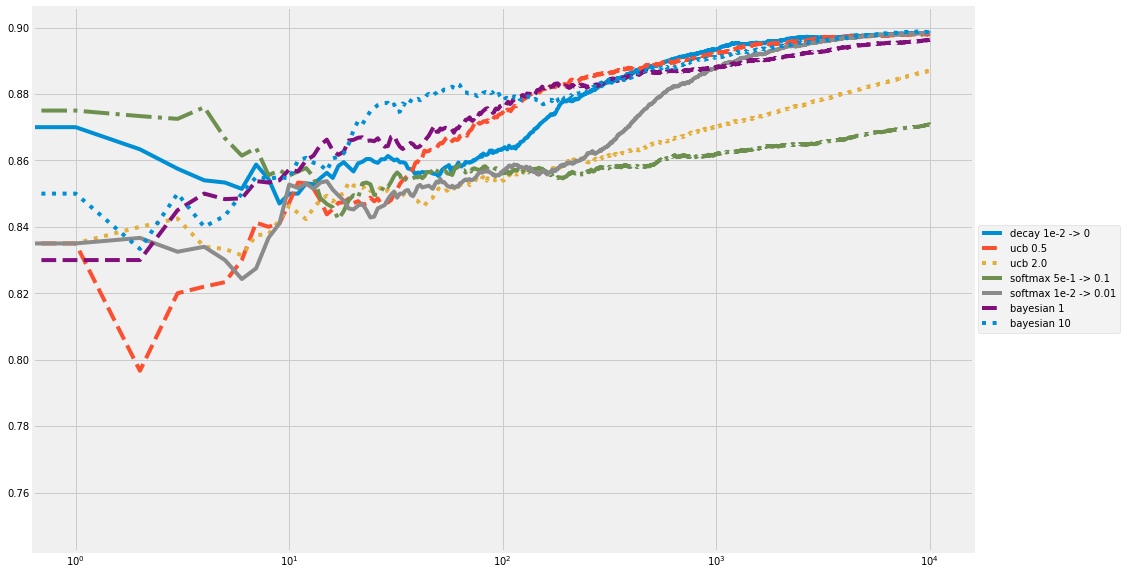

In [8]:
plt.figure(figsize=(15, 10))
lines = ["-","--",":","-."]
linecycler = cycle(lines)
for experiment, label in results:
    plt.plot(np.mean(experiment, axis=0), next(linecycler), label=label)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xscale('log')
plt.show()

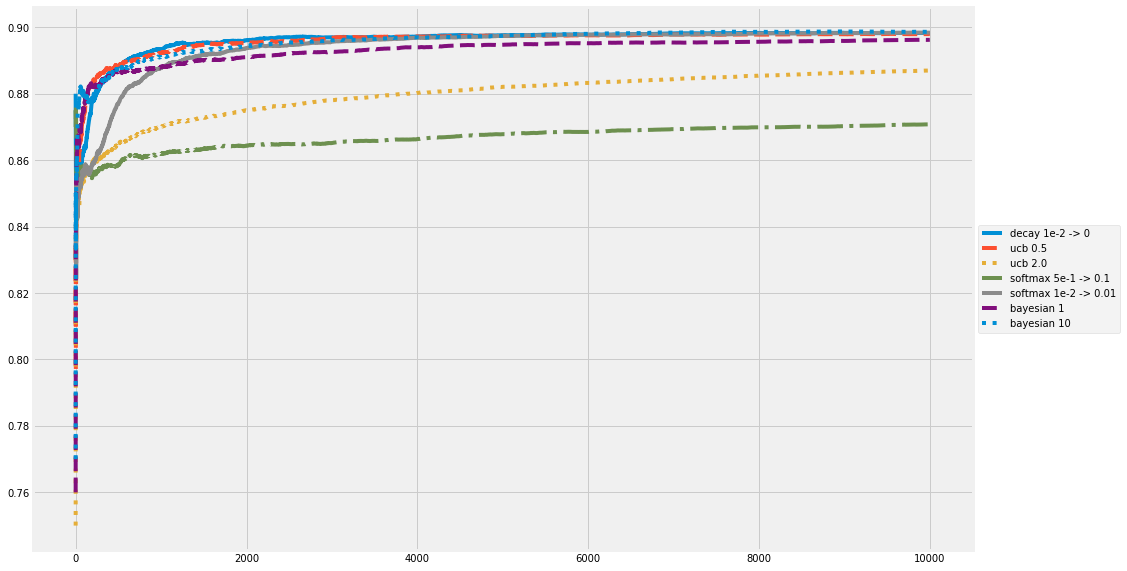

In [9]:
plt.figure(figsize=(15, 10))
lines = ["-","--",":","-."]
linecycler = cycle(lines)
for experiment, label in results:
    plt.plot(np.mean(experiment, axis=0), next(linecycler), label=label)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

We now run the strategies on a 10-arm Gaussian bandit environment.

In [10]:
env = gym.make("BanditTenArmedGaussian-v0")
results = run_exploration_strategies_experiment(env)

100%|██████████| 100/100 [03:11<00:00,  1.92s/it]


And we plot the same way as before.

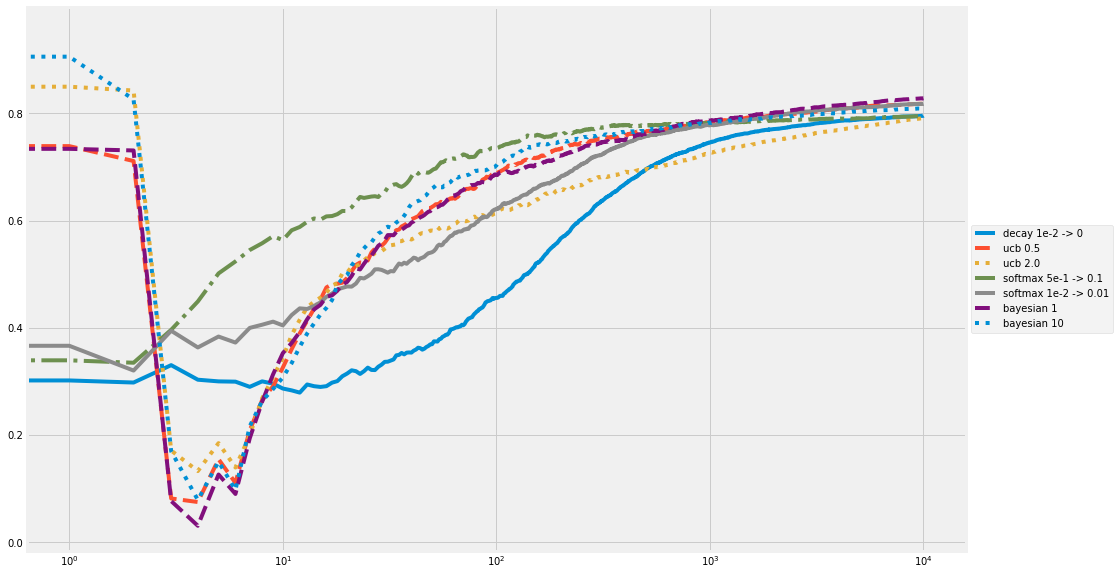

In [11]:
plt.figure(figsize=(15, 10))
lines = ["-","--",":","-."]
linecycler = cycle(lines)
for experiment, label in results:
    plt.plot(np.mean(experiment, axis=0), next(linecycler), label=label)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xscale('log')
plt.show()

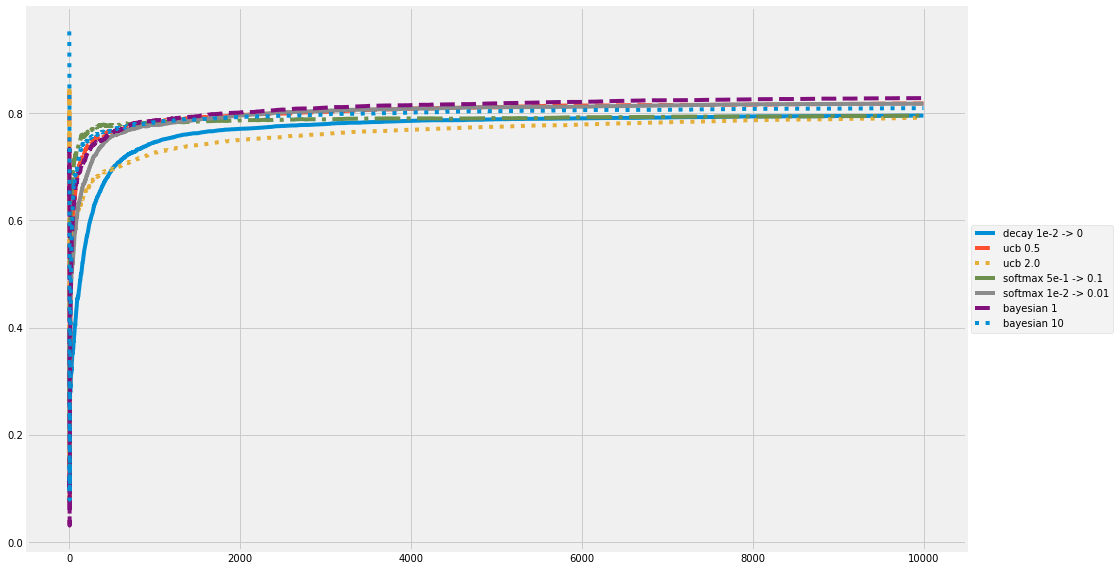

In [12]:
plt.figure(figsize=(15, 10))
lines = ["-","--",":","-."]
linecycler = cycle(lines)
for experiment, label in results:
    plt.plot(np.mean(experiment, axis=0), next(linecycler), label=label)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

We bring the same helper methods as in previous Notebooks.

In [13]:
def print_policy(pi, P):
    arrs = {k:v for k,v in enumerate(('<', 'v', '>', '^'))}
    for key, value in pi.items():
        print("| ", end="")
        if P[key][0][0][0] == 1.0:
            print("    ", end=" ")
        else:
            print(str(key).zfill(2), arrs[value], end=" ")
        if (key + 1) % np.sqrt(len(pi)) == 0: print("|")

In [14]:
def plot_value_function(V_track, log=False):
    per_col = 25
    plt.figure(figsize=(15, 10))
    linecycler = cycle(["-","--",":","-."])
    legends = []
    for i, state in enumerate(V_track.T):
        p, = plt.plot(state, next(linecycler), label=str('State {}'.format(i)))
        legends.append(p)
    ls = []
    for loc, idx in enumerate(range(0, len(legends), per_col)):
        subset = legends[idx:idx+per_col]
        l = plt.legend(subset, [p.get_label() for p in subset], 
                       loc='center left', bbox_to_anchor=(1+loc*0.15, 0.5))
        ls.append(l)
    [plt.gca().add_artist(l) for l in ls[:-1]]
    if log: plt.xscale('log')
    plt.show()

In [15]:
def probability_success(env, pi, iterations=10000):
    rewards = []
    for i in range(iterations):
        state, done = env.reset(), False
        while not done:
            state, reward, done, _ = env.step(pi[state])
            rewards.append(reward)
    return np.sum(rewards)/iterations*iterations/100

We import the 8x8 FrozenLake environment and update the transition probabilities.

In [16]:
env = gym.make('FrozenLake8x8-v0')

# change transition function
prob_action, drift_right, drift_left = 0.8, 0.1, 0.1
for s in range(len(env.env.P)):
    for a in range(len(env.env.P[s])):
        for t in range(len(env.env.P[s][a])):
            if env.env.P[s][a][t][0] == 1.0:
                continue
            values = list(env.env.P[s][a][t])
            if t == 0:
                values[0] = drift_left
            elif t == 1:
                values[0] = prob_action
            elif t == 2:
                values[0] = drift_right
            env.env.P[s][a][t] = tuple(values)

We create a policy to evaluate it with all different algorithms.

In [17]:
LEFT, DOWN, RIGHT, UP = range(4)
HOLE = GOAL = LEFT
pi = {
     0: RIGHT,  1: RIGHT,  2: RIGHT,  3: RIGHT,  4: RIGHT,  5: RIGHT,  6: RIGHT,  7: DOWN,
     8: RIGHT,  9: RIGHT, 10: RIGHT, 11: RIGHT, 12: RIGHT, 13: RIGHT, 14: RIGHT, 15: DOWN,
    16: UP,    17: UP,    18: UP,    19: HOLE,  20: UP,    21: UP,    22: RIGHT, 23: DOWN,
    24: RIGHT, 25: RIGHT, 26: RIGHT, 27: RIGHT, 28: DOWN,  29: HOLE,  30: RIGHT, 31: DOWN,
    32: UP,    33: UP,    34: UP,    35: HOLE,  36: RIGHT, 37: RIGHT, 38: RIGHT, 39: DOWN, 
    40: UP,    41: HOLE,  42: HOLE,  43: RIGHT, 44: RIGHT, 45: DOWN,  46: HOLE,  47: DOWN,
    48: UP,    49: HOLE,  50: RIGHT, 51: UP,    52: LEFT,  53: DOWN,  54: HOLE,  55: DOWN,
    56: RIGHT, 57: RIGHT, 58: UP,    59: HOLE,  60: RIGHT, 61: RIGHT, 62: RIGHT, 63: GOAL
}

For comparison, we run policy evaluation on this environment and policy and calculate the true value function for that policy.

In [18]:
def policy_evaluation(pi, P, gamma=0.9, theta=1e-10):
    V = np.zeros(len(pi))
    V_track = []
    while True:
        max_delta = 0
        old_V = V.copy()

        for s in range(len(P)):
            V[s] = 0
            for prob, new_state, reward, done in P[s][pi[s]]:
                if done:
                    value = reward
                else:
                    value = reward + gamma * old_V[new_state]
                V[s] += prob * value
            max_delta = max(max_delta, abs(old_V[s] - V[s]))
        V_track.append(V.copy())
        if max_delta < theta:
            break
    return V.copy(), np.array(V_track)

V, V_track = policy_evaluation(pi, env.env.P)
V, V_track

(array([ 0.13750773,  0.15745219,  0.18027104,  0.20632766,  0.2358301 ,
         0.2666409 ,  0.30024891,  0.33674783,  0.1307384 ,  0.14984824,
         0.17211932,  0.19956104,  0.25137715,  0.29404446,  0.34186753,
         0.38808072,  0.11635525,  0.13057368,  0.13567754,  0.        ,
         0.2048937 ,  0.26557945,  0.39363347,  0.44775747,  0.11422956,
         0.13139449,  0.15185496,  0.17899462,  0.24860364,  0.        ,
         0.44977797,  0.51671151,  0.10170612,  0.11452544,  0.11964286,
         0.        ,  0.3229085 ,  0.37616262,  0.47020747,  0.59684369,
         0.08047078,  0.        ,  0.        ,  0.25536327,  0.32996766,
         0.41792486,  0.        ,  0.69556817,  0.06366919,  0.        ,
         0.15296446,  0.19762835,  0.        ,  0.53920523,  0.        ,
         0.87912088,  0.08052826,  0.09382013,  0.11857822,  0.        ,
         0.59253322,  0.74889616,  0.87912088,  0.        ]),
 array([[ 0.        ,  0.        ,  0.        , ...,  0.      

In [20]:
probability_success(env, pi)

75.090000000000003

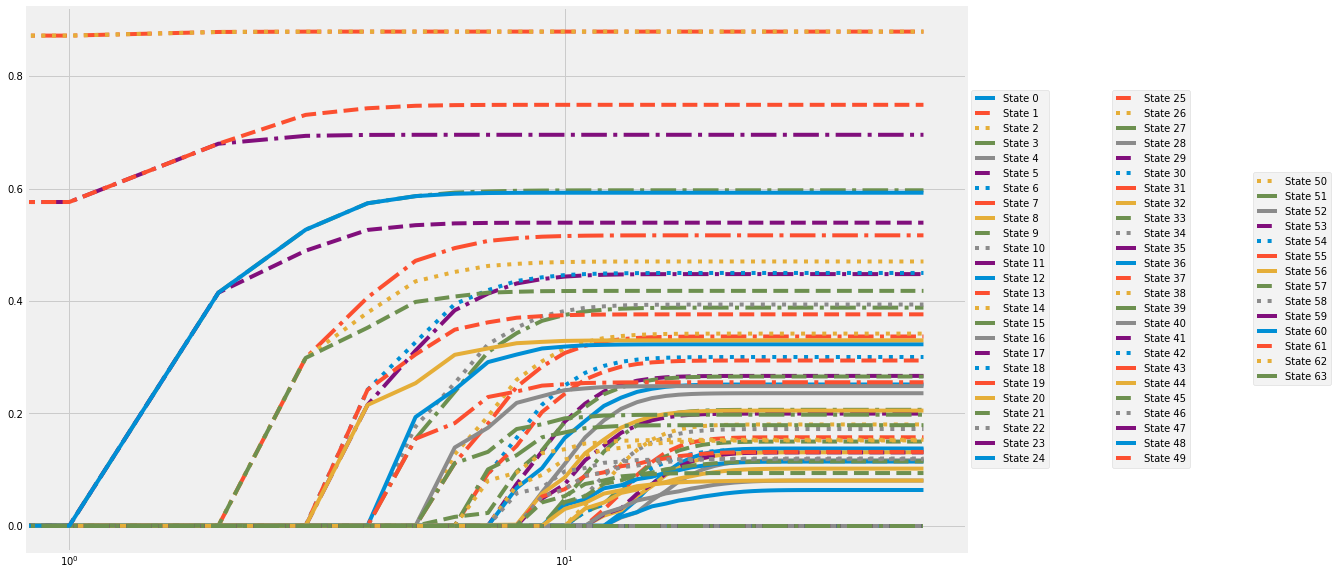

In [21]:
plot_value_function(V_track, True)

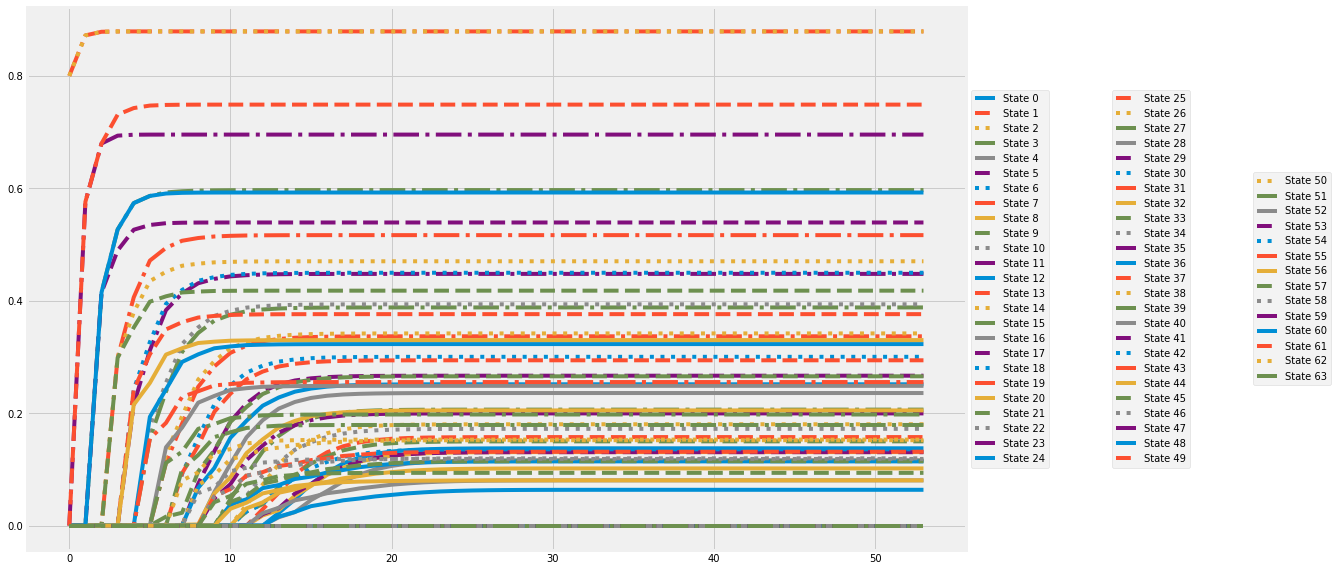

In [22]:
plot_value_function(V_track)

We bring TD and implement TD(lambda) and compare their results.

In [23]:
def td(pi, 
       env, 
       gamma=0.9, 
       initial_alpha=0.2, 
       alpha_decay_rate=1e-3, 
       min_alpha=0.0, 
       n_episodes=10000):
    nS = env.observation_space.n
    V = np.zeros(nS)
    V_track = np.zeros((n_episodes, nS))
    
    for t in tqdm(range(n_episodes)):
        alpha = max(initial_alpha * np.exp(-alpha_decay_rate * t), min_alpha)

        state, done = env.reset(), False
        while not done:
            action = pi[state]
            new_state, reward, done, _ = env.step(action)
            td_error = reward + gamma * V[new_state] - V[state]
            V[state] = V[state] + alpha * td_error
            state = new_state
        V_track[t] = V
    return V.copy(), V_track

V, V_track = td(pi, env)
V

100%|██████████| 10000/10000 [00:01<00:00, 6130.04it/s]


array([ 0.13862109,  0.15959815,  0.1830051 ,  0.2095673 ,  0.23888136,
        0.26938407,  0.30342271,  0.34072408,  0.12892208,  0.1504888 ,
        0.17357069,  0.20106523,  0.25398319,  0.29624294,  0.34469819,
        0.39222869,  0.10435162,  0.12716928,  0.13935497,  0.        ,
        0.20429814,  0.26699575,  0.39778937,  0.45059541,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.45570354,  0.51814435,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.48739396,  0.59793255,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.69499977,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.88119632,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ])

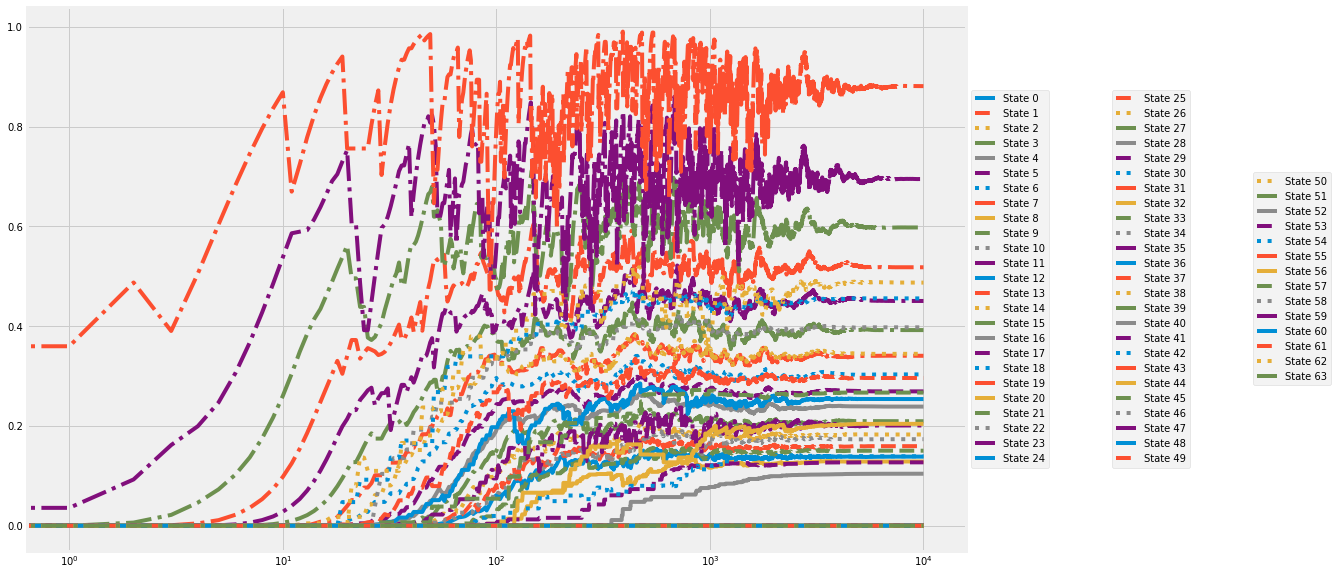

In [24]:
plot_value_function(V_track, True)

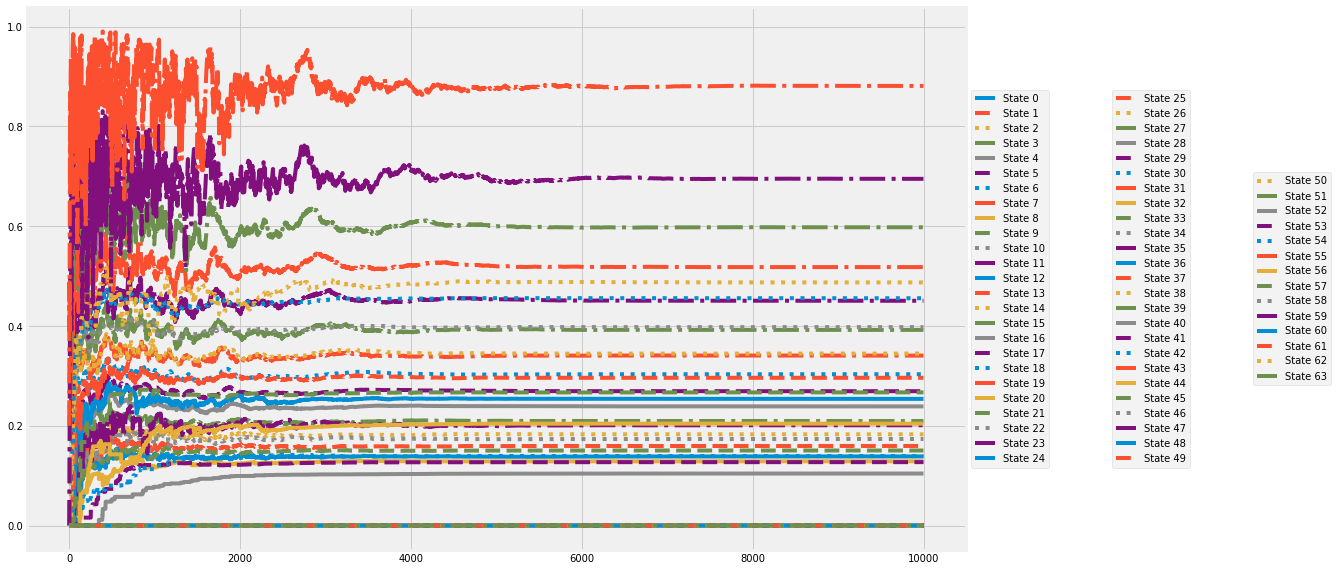

In [25]:
plot_value_function(V_track)

Now, TD(Lambda).

In [26]:
def td_lambda(pi, 
              env, 
              gamma=0.9, 
              lambda_=0.5, 
              initial_alpha=0.2, 
              alpha_decay_rate=1e-3, 
              min_alpha=0.0, 
              n_episodes=10000):
    nS = env.observation_space.n
    V = np.zeros(nS)
    E = np.zeros(nS)
    V_track = np.zeros((n_episodes, nS))
    
    for t in tqdm(range(n_episodes)):
        alpha = max(initial_alpha * np.exp(-alpha_decay_rate * t), min_alpha)
        E.fill(0)

        state, done = env.reset(), False
        while not done:
            action = pi[state]
            new_state, reward, done, _ = env.step(action)
            td_error = reward + gamma * V[new_state] - V[state]
            E[state] = E[state] + 1
            V = V + alpha * td_error * E
            E = gamma * lambda_ * E
            state = new_state
        V_track[t] = V
    return V.copy(), V_track

V, V_track = td_lambda(pi, env)
V

100%|██████████| 10000/10000 [00:02<00:00, 4026.35it/s]


array([ 0.13872363,  0.15891955,  0.18145961,  0.20687037,  0.23593881,
        0.26607738,  0.2992944 ,  0.33573489,  0.13286308,  0.15184207,
        0.17474535,  0.20115772,  0.25069443,  0.29437611,  0.34140279,
        0.38624283,  0.11173417,  0.12867919,  0.13484962,  0.        ,
        0.19785017,  0.26303601,  0.39510326,  0.44572627,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.45193032,  0.51264863,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.46340336,  0.59247805,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.68867795,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.87092275,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ])

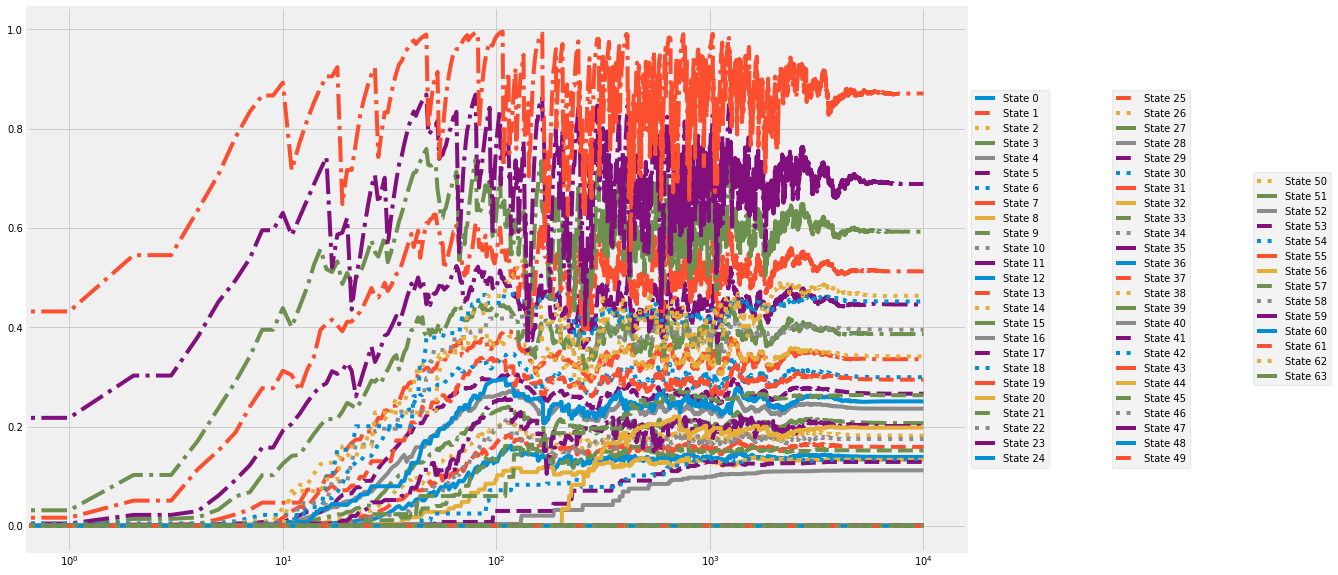

In [27]:
plot_value_function(V_track, True)

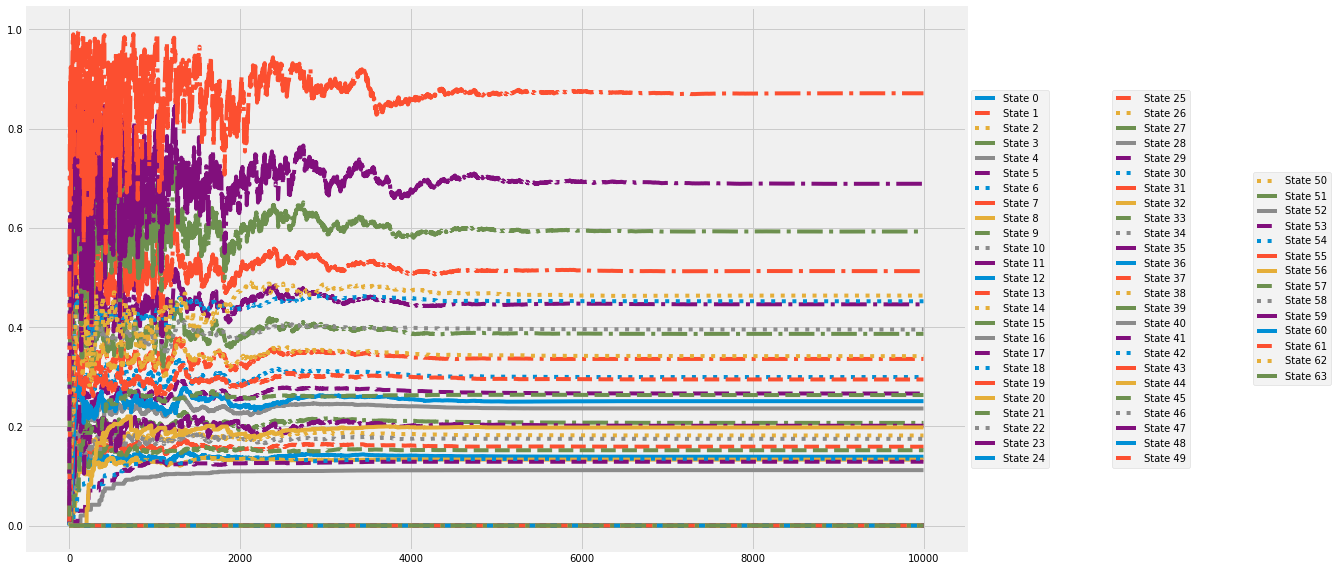

In [28]:
plot_value_function(V_track)

Let's "zoom-in" and compare them on less number of iterations.

100%|██████████| 10/10 [00:00<00:00, 3209.35it/s]


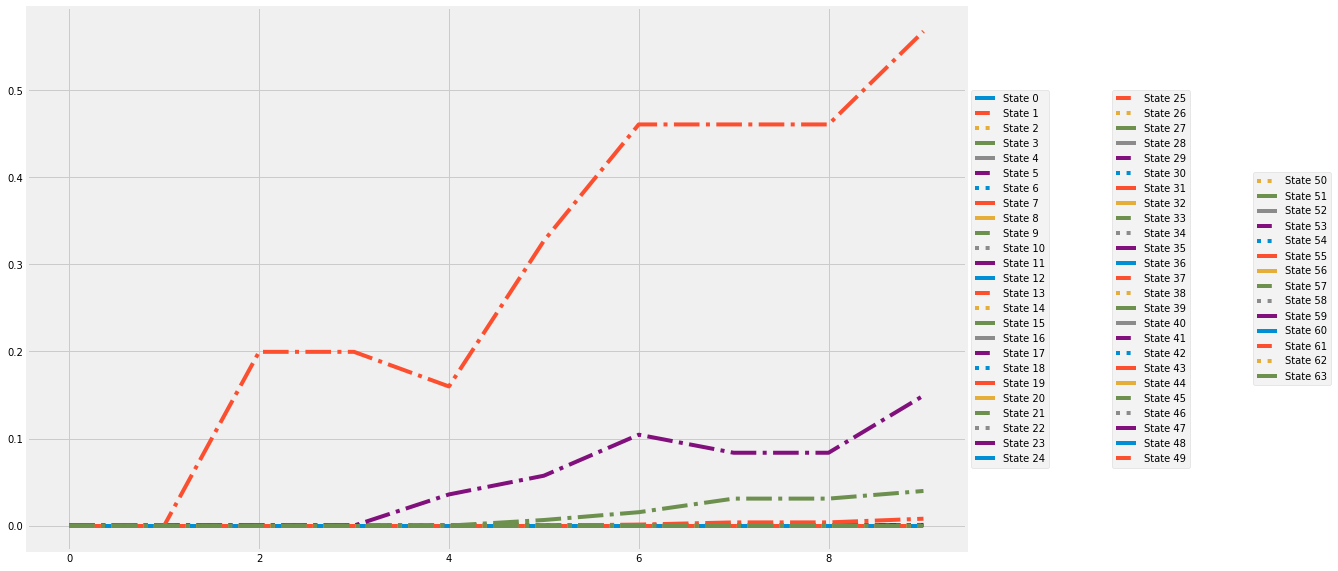

In [29]:
V, V_track = td(pi, env, n_episodes=10)
plot_value_function(V_track)

100%|██████████| 10/10 [00:00<00:00, 1723.50it/s]


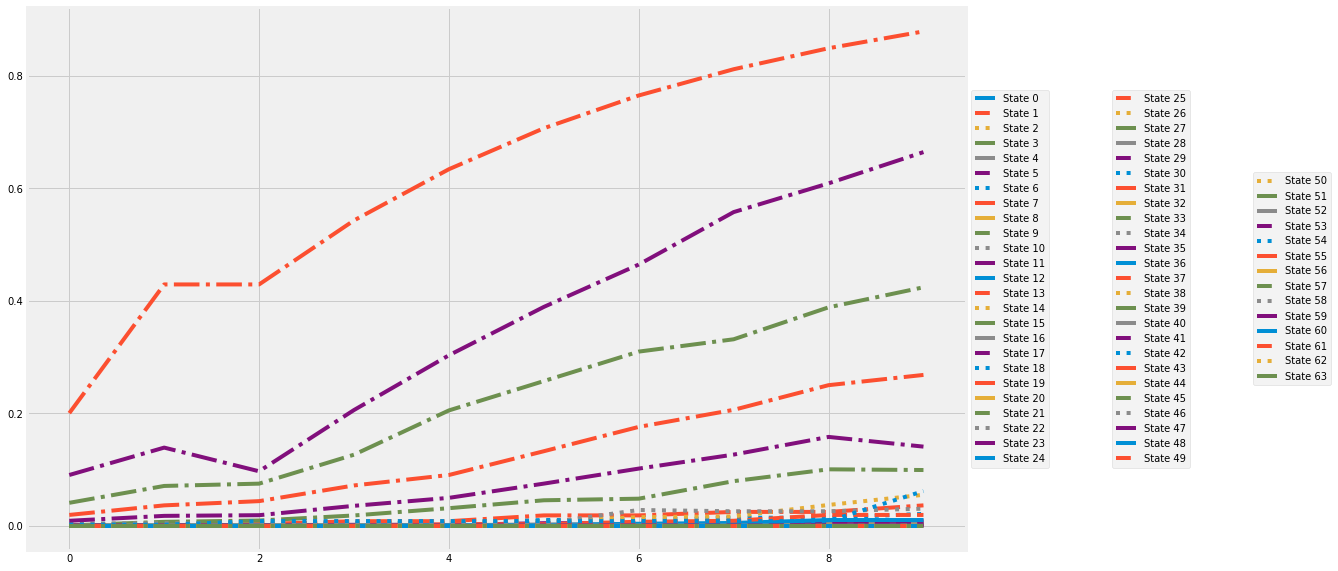

In [30]:
V, V_track = td_lambda(pi, env, n_episodes=10)
plot_value_function(V_track)

See how the value functions are being "lifted" or update more quickly?

Let's do the same with SARSA.

In [31]:
def sarsa(env,
          gamma = 0.9,
          initial_alpha = 1.0,
          alpha_decay_rate = 5e-4,
          min_alpha = 1e-4,
          initial_epsilon = 1.,
          epsilon_decay_rate = 1e-5,
          min_epsilon = 0.0,
          n_episodes=100000):

    nS, nA = env.observation_space.n, env.action_space.n
    Q = np.zeros((nS, nA))
    Q_track = np.zeros((n_episodes, nS, nA))
    select_action = lambda state, Q, epsilon: np.argmax(Q[state]) \
        if np.random.random() > epsilon \
        else np.random.randint(nA)
    
    for t in tqdm(range(n_episodes)):
        alpha = max(initial_alpha * np.exp(-alpha_decay_rate * t), min_alpha)
        epsilon = max(initial_epsilon * np.exp(-epsilon_decay_rate * t), min_epsilon)
        state, done = env.reset(), False
        action = select_action(state, Q, epsilon)
        while not done:
            new_state, reward, done, _ = env.step(action)
            new_action = select_action(new_state, Q, epsilon)
            
            if done:
                Q[new_state] = 0.
                Q_est = reward
            else: 
                Q_est = reward + gamma * Q[new_state][new_action]
            Q[state][action] += alpha * (Q_est - Q[state][action])
            state, action = new_state, new_action
        Q_track[t] = Q

    pi = {s:a for s, a in enumerate(np.argmax(Q, axis=1))}
    V = np.max(Q, axis=1)
    return Q, V, pi, Q_track

Q_best, V_best, pi_best, Q_track = sarsa(env)
Q_best, V_best, pi_best

100%|██████████| 100000/100000 [00:36<00:00, 2716.46it/s]


(array([[ 0.00008373,  0.00006609,  0.00016979,  0.00009242],
        [ 0.00008971,  0.00010622,  0.00028191,  0.00013709],
        [ 0.00014284,  0.0001994 ,  0.00046787,  0.00022723],
        [ 0.00024936,  0.00039847,  0.0007786 ,  0.00038085],
        [ 0.00044555,  0.00129284,  0.00075962,  0.00060716],
        [ 0.0003896 ,  0.00090104,  0.00199502,  0.00042256],
        [ 0.0011028 ,  0.00406117,  0.0018434 ,  0.00155486],
        [ 0.00153574,  0.00437635,  0.00154104,  0.00132403],
        [ 0.00004577,  0.00003297,  0.0000686 ,  0.00009492],
        [ 0.00004823,  0.00004085,  0.00020458,  0.00010226],
        [ 0.00008383,  0.00007894,  0.00046622,  0.00019472],
        [ 0.00015221,  0.00009544,  0.00106889,  0.00035722],
        [ 0.00043587,  0.00081278,  0.00251886,  0.00070763],
        [ 0.00097084,  0.00214002,  0.00518076,  0.00112292],
        [ 0.00222903,  0.01126986,  0.00484415,  0.00209841],
        [ 0.00333747,  0.01512758,  0.00455291,  0.00205271],
        

In [32]:
probability_success(env, pi_best)

72.640000000000015

In [33]:
print_policy(pi_best, env.env.P)

| 00 > | 01 > | 02 > | 03 > | 04 v | 05 > | 06 v | 07 v |
| 08 ^ | 09 > | 10 > | 11 > | 12 > | 13 > | 14 v | 15 v |
| 16 ^ | 17 ^ | 18 ^ |      | 20 > | 21 > | 22 v | 23 v |
| 24 ^ | 25 > | 26 > | 27 > | 28 ^ |      | 30 > | 31 v |
| 32 ^ | 33 ^ | 34 ^ |      | 36 > | 37 > | 38 > | 39 v |
| 40 ^ |      |      | 43 > | 44 ^ | 45 ^ |      | 47 v |
| 48 ^ |      | 50 v | 51 ^ |      | 53 ^ |      | 55 v |
| 56 ^ | 57 < | 58 < |      | 60 ^ | 61 > | 62 ^ |      |


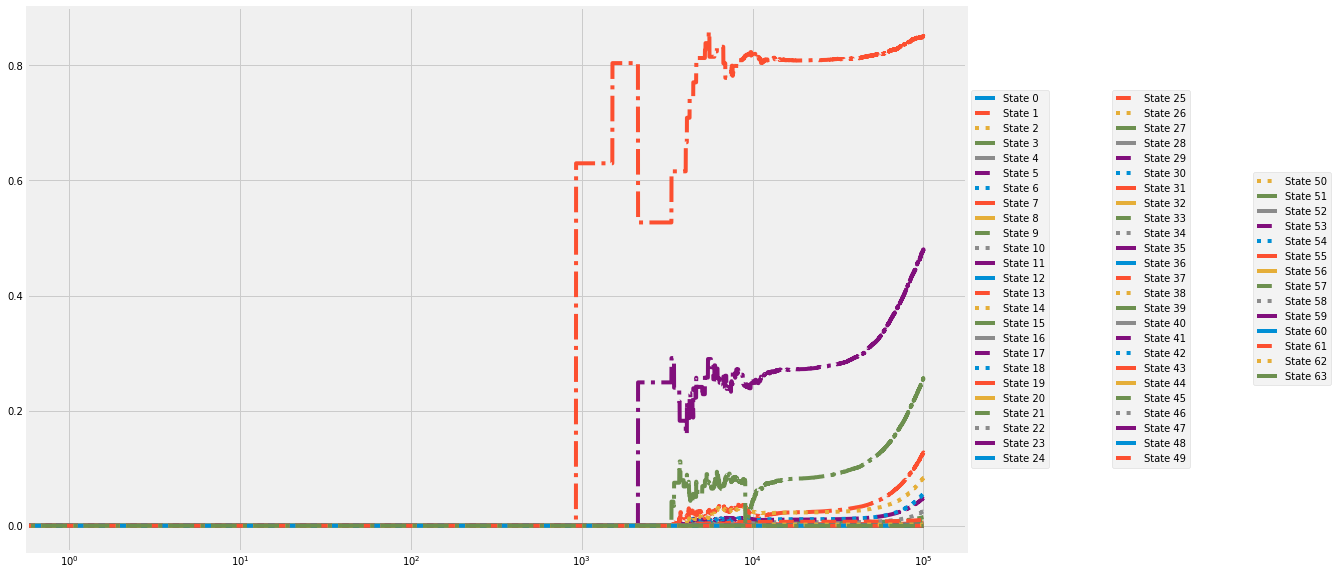

In [34]:
plot_value_function(np.max(Q_track, axis=2), True)

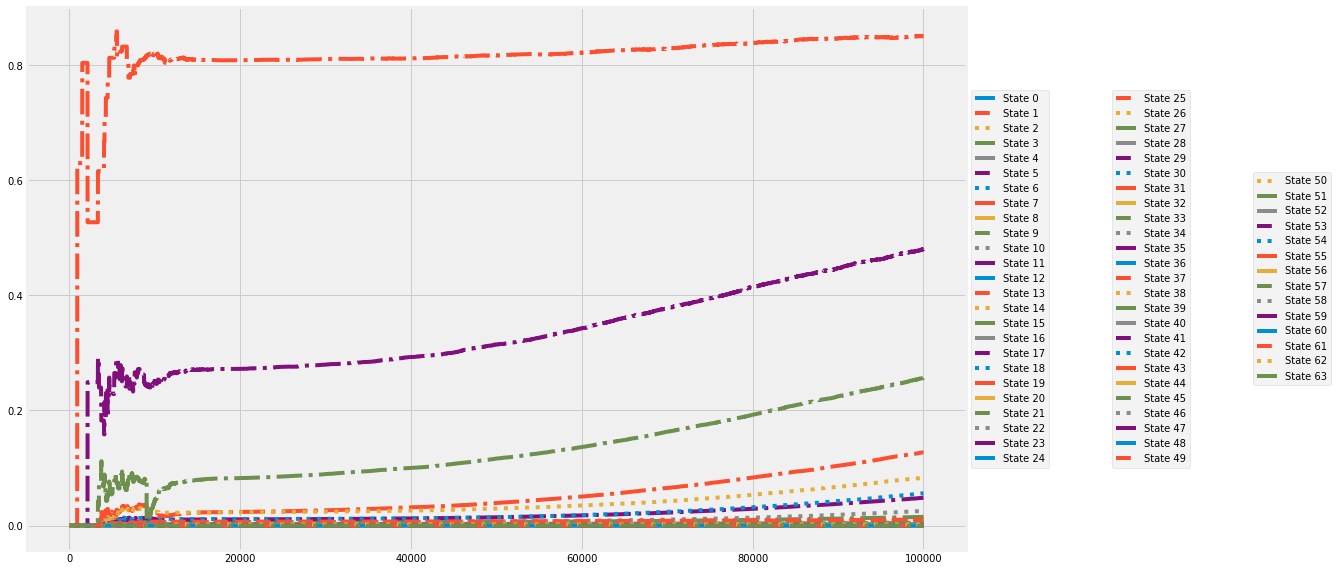

In [35]:
plot_value_function(np.max(Q_track, axis=2))

Now, for SARSA(Lambda).

In [36]:
def sarsa_lambda(env,
                 gamma = 0.9,
                 lambda_ = 0.5,
                 initial_alpha = 1.0,
                 alpha_decay_rate = 5e-4,
                 min_alpha = 1e-4,
                 initial_epsilon = 1.,
                 epsilon_decay_rate = 1e-5,
                 min_epsilon = 0.0,
                 n_episodes=100000):

    nS, nA = env.observation_space.n, env.action_space.n
    Q = np.zeros((nS, nA))
    Q_track = np.zeros((n_episodes, nS, nA))
    E = np.zeros((nS, nA))
    select_action = lambda state, Q, epsilon: np.argmax(Q[state]) \
        if np.random.random() > epsilon \
        else np.random.randint(nA)
    
    for t in tqdm(range(n_episodes)):
        alpha = max(initial_alpha * np.exp(-alpha_decay_rate * t), min_alpha)
        epsilon = max(initial_epsilon * np.exp(-epsilon_decay_rate * t), min_epsilon)
        E.fill(0)

        state, done = env.reset(), False
        action = select_action(state, Q, epsilon)
        while not done:
            new_state, reward, done, _ = env.step(action)
            new_action = select_action(new_state, Q, epsilon)
            
            if done:
                Q[new_state] = 0.
                Q_est = reward
            else: 
                Q_est = reward + gamma * Q[new_state][new_action]
            E[state][action] = E[state][action] + 1
            Q = Q + alpha * (Q_est - Q[state][action]) * E
            E = gamma * lambda_ * E
            
            state, action = new_state, new_action

        Q_track[t] = Q

    pi = {s:a for s, a in enumerate(np.argmax(Q, axis=1))}
    V = np.max(Q, axis=1)
    return Q, V, pi, Q_track

Q_best, V_best, pi_best, Q_track = sarsa_lambda(env)
Q_best, V_best, pi_best

100%|██████████| 100000/100000 [00:54<00:00, 1820.41it/s]


(array([[ 0.00048526,  0.00041228,  0.00146732,  0.00052519],
        [ 0.00050807,  0.00065122,  0.00238826,  0.00076818],
        [ 0.00076877,  0.00109087,  0.00393729,  0.00122943],
        [ 0.00124787,  0.00196583,  0.00644538,  0.00199136],
        [ 0.00219585,  0.00379096,  0.01045606,  0.00320589],
        [ 0.00378282,  0.00712767,  0.01673893,  0.0053017 ],
        [ 0.0056672 ,  0.02561411,  0.00965729,  0.00735744],
        [ 0.00578761,  0.02361276,  0.00716868,  0.00652275],
        [ 0.00021432,  0.0001613 ,  0.00075605,  0.00028807],
        [ 0.0002703 ,  0.00027387,  0.00162674,  0.00052722],
        [ 0.00047164,  0.00046853,  0.00322249,  0.00094568],
        [ 0.00074269,  0.00039864,  0.00634838,  0.00162621],
        [ 0.00168972,  0.00320538,  0.01270745,  0.00285356],
        [ 0.00413494,  0.00839071,  0.0253053 ,  0.00518579],
        [ 0.01016396,  0.04770211,  0.0208242 ,  0.01011819],
        [ 0.01265683,  0.06168765,  0.01697621,  0.00958253],
        

In [37]:
probability_success(env, pi_best)

74.890000000000001

In [38]:
print_policy(pi_best, env.env.P)

| 00 > | 01 > | 02 > | 03 > | 04 > | 05 > | 06 v | 07 v |
| 08 > | 09 > | 10 > | 11 > | 12 > | 13 > | 14 v | 15 v |
| 16 ^ | 17 ^ | 18 ^ |      | 20 > | 21 > | 22 > | 23 v |
| 24 ^ | 25 > | 26 > | 27 > | 28 v |      | 30 > | 31 v |
| 32 ^ | 33 ^ | 34 ^ |      | 36 > | 37 > | 38 > | 39 v |
| 40 ^ |      |      | 43 > | 44 > | 45 ^ |      | 47 v |
| 48 ^ |      | 50 > | 51 ^ |      | 53 v |      | 55 v |
| 56 ^ | 57 < | 58 < |      | 60 > | 61 > | 62 > |      |


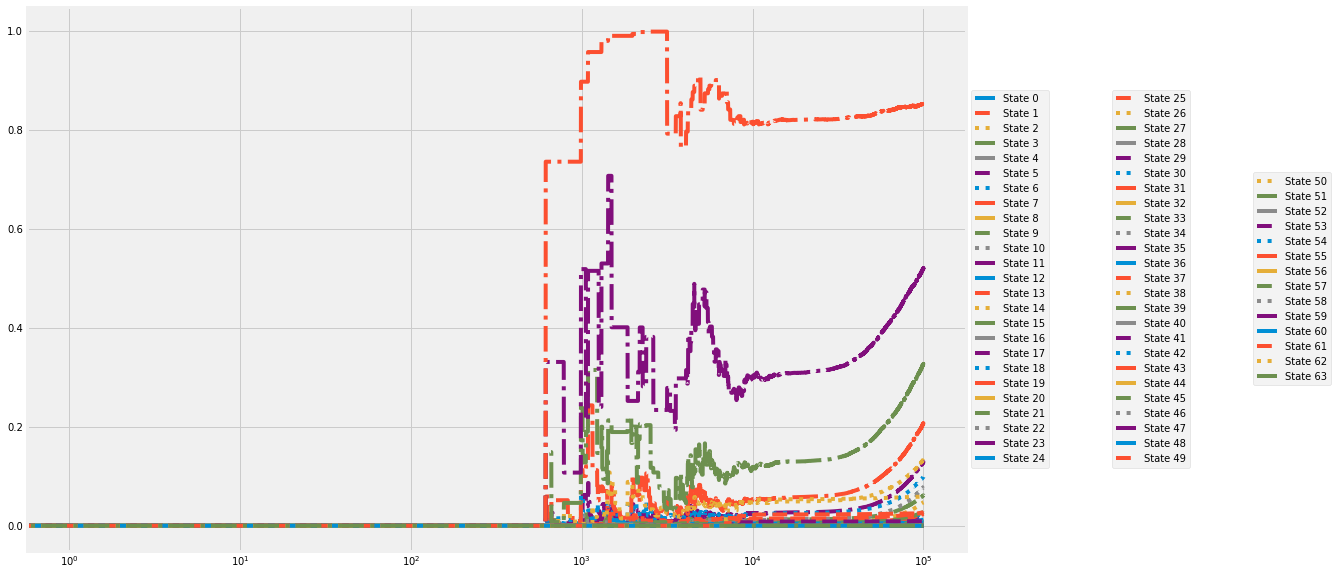

In [39]:
plot_value_function(np.max(Q_track, axis=2), True)

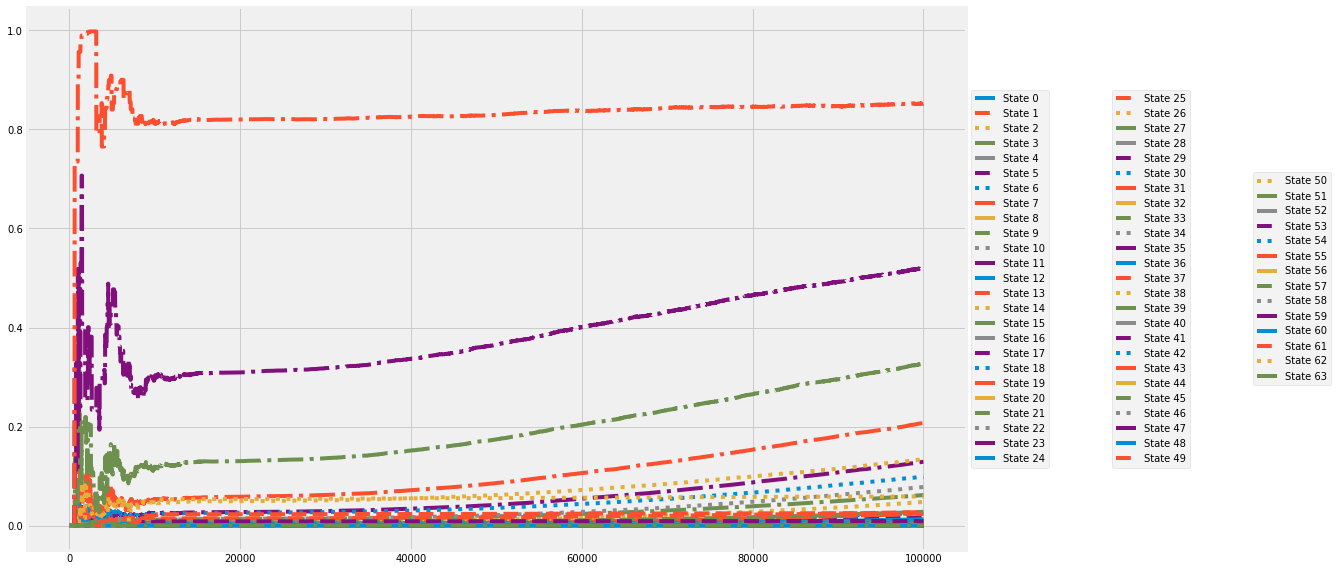

In [40]:
plot_value_function(np.max(Q_track, axis=2))

Compare them on a shorted number of episode. (Trying to "zoom-in", but not quite because we don't know when is the first time we hit a reward, that is partly up to chance)

100%|██████████| 1000/1000 [00:00<00:00, 2365.18it/s]


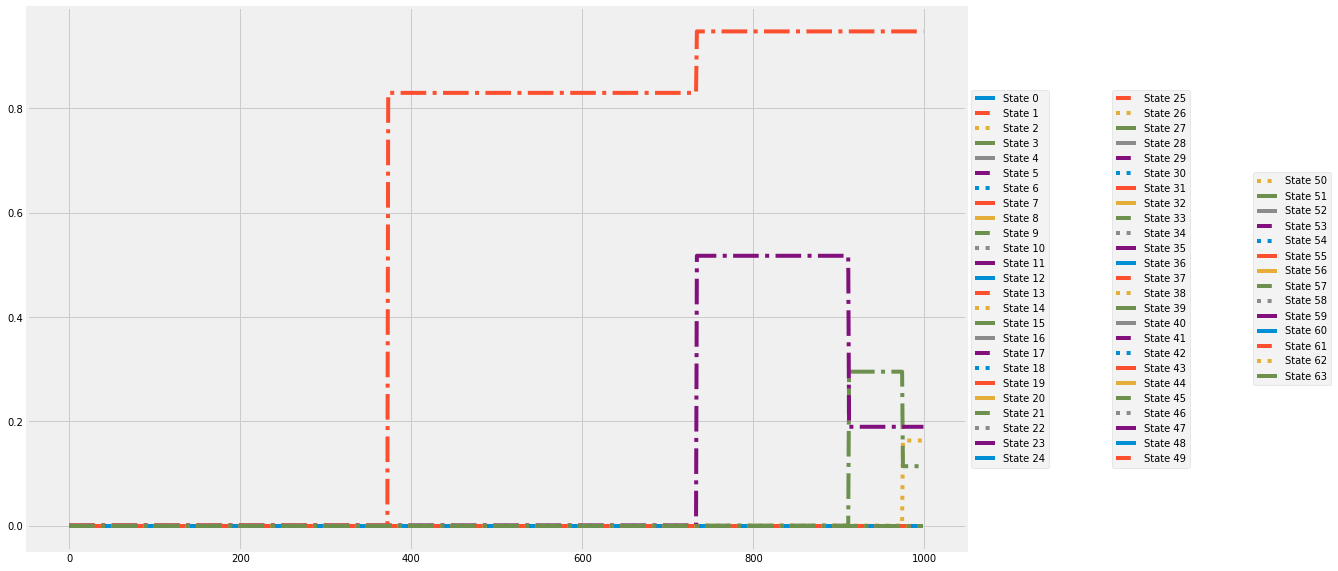

In [41]:
Q_best, V_best, pi_best, Q_track = sarsa(env, n_episodes=1000)
plot_value_function(np.max(Q_track, axis=2))

100%|██████████| 1000/1000 [00:00<00:00, 1638.34it/s]


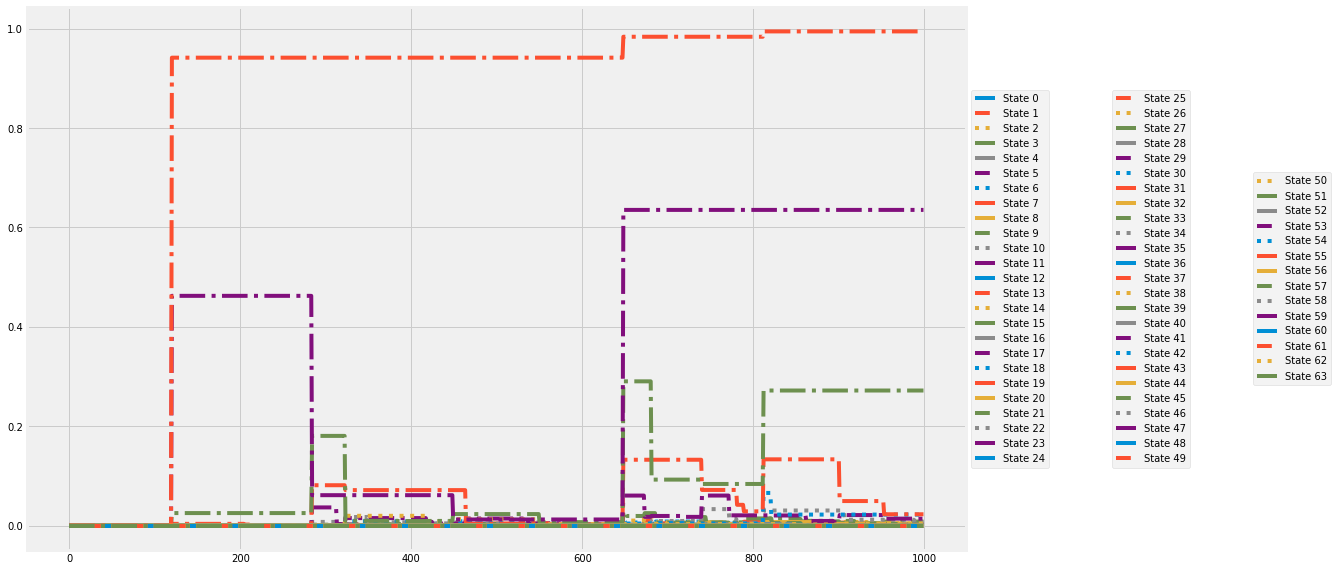

In [42]:
Q_best, V_best, pi_best, Q_track = sarsa_lambda(env, n_episodes=1000)
plot_value_function(np.max(Q_track, axis=2))

Though, you can see that when you do "hit chance" and get a reward only a single value function gets updated with SARSA, while SARSA(Lambda) has many updates on the first encounter, and many other based on the new values. 

We can do the same thing for Q-Learning.

In [43]:
def q_learning(env, 
               gamma = 0.9,
               initial_alpha = 0.5,
               alpha_decay_rate = 1e-3,
               min_alpha = 0.001,
               initial_epsilon = 1.,
               epsilon_decay_rate = 1e-5,
               min_epsilon = 0.0,
               n_episodes=100000):

    nS, nA = env.observation_space.n, env.action_space.n
    Q = np.zeros((nS, nA))
    Q_track = np.zeros((n_episodes, nS, nA))
    select_action = lambda state, Q, epsilon: np.argmax(Q[state]) \
        if np.random.random() > epsilon \
        else np.random.randint(nA)
    
    for t in tqdm(range(n_episodes)):
        alpha = max(initial_alpha * np.exp(-alpha_decay_rate * t), min_alpha)
        epsilon = max(initial_epsilon * np.exp(-epsilon_decay_rate * t), min_epsilon)
        state, done = env.reset(), False
        while not done:
            action = select_action(state, Q, epsilon)
            new_state, reward, done, _ = env.step(action)
            if done:
                Q[new_state] = 0.
                Q_est = reward
            else: 
                Q_est = reward + gamma * Q[new_state].max()
            Q[state][action] = Q[state][action] + alpha * (Q_est - Q[state][action])
            state = new_state
        Q_track[t] = Q

    pi = {s:a for s, a in enumerate(np.argmax(Q, axis=1))}
    V = np.max(Q, axis=1)
    return Q, V, pi, Q_track

Q_best, V_best, pi_best, Q_track = q_learning(env)
Q_best, V_best, pi_best

100%|██████████| 100000/100000 [00:48<00:00, 2074.31it/s]


(array([[ 0.12318515,  0.12023306,  0.13877233,  0.12578469],
        [ 0.12678303,  0.13769533,  0.15863125,  0.14213034],
        [ 0.14560211,  0.15840122,  0.18167862,  0.16314867],
        [ 0.1664606 ,  0.18416731,  0.20814241,  0.18550513],
        [ 0.19242142,  0.22868803,  0.23706966,  0.21148863],
        [ 0.21939166,  0.26232716,  0.26753953,  0.23858642],
        [ 0.24817612,  0.30042069,  0.29797672,  0.26842068],
        [ 0.27773634,  0.33363672,  0.30381827,  0.29586294],
        [ 0.10464344,  0.08677285,  0.13144096,  0.11615364],
        [ 0.11534674,  0.11576571,  0.15269608,  0.13872216],
        [ 0.13527597,  0.12614557,  0.17595836,  0.16043006],
        [ 0.14119481,  0.03909039,  0.20476591,  0.18557819],
        [ 0.187639  ,  0.22388981,  0.25929751,  0.21201575],
        [ 0.23546267,  0.27483131,  0.29877945,  0.24375778],
        [ 0.27472898,  0.3430323 ,  0.33939028,  0.27692674],
        [ 0.31629924,  0.38525387,  0.34695228,  0.30467552],
        

In [44]:
probability_success(env, pi_best)

74.0

In [45]:
print_policy(pi_best, env.env.P)

| 00 > | 01 > | 02 > | 03 > | 04 > | 05 > | 06 v | 07 v |
| 08 > | 09 > | 10 > | 11 > | 12 > | 13 > | 14 v | 15 v |
| 16 > | 17 ^ | 18 ^ |      | 20 > | 21 > | 22 > | 23 v |
| 24 > | 25 ^ | 26 ^ | 27 > | 28 ^ |      | 30 > | 31 v |
| 32 ^ | 33 ^ | 34 ^ |      | 36 > | 37 > | 38 > | 39 v |
| 40 ^ |      |      | 43 > | 44 ^ | 45 ^ |      | 47 v |
| 48 ^ |      | 50 v | 51 ^ |      | 53 ^ |      | 55 v |
| 56 ^ | 57 < | 58 < |      | 60 > | 61 > | 62 > |      |


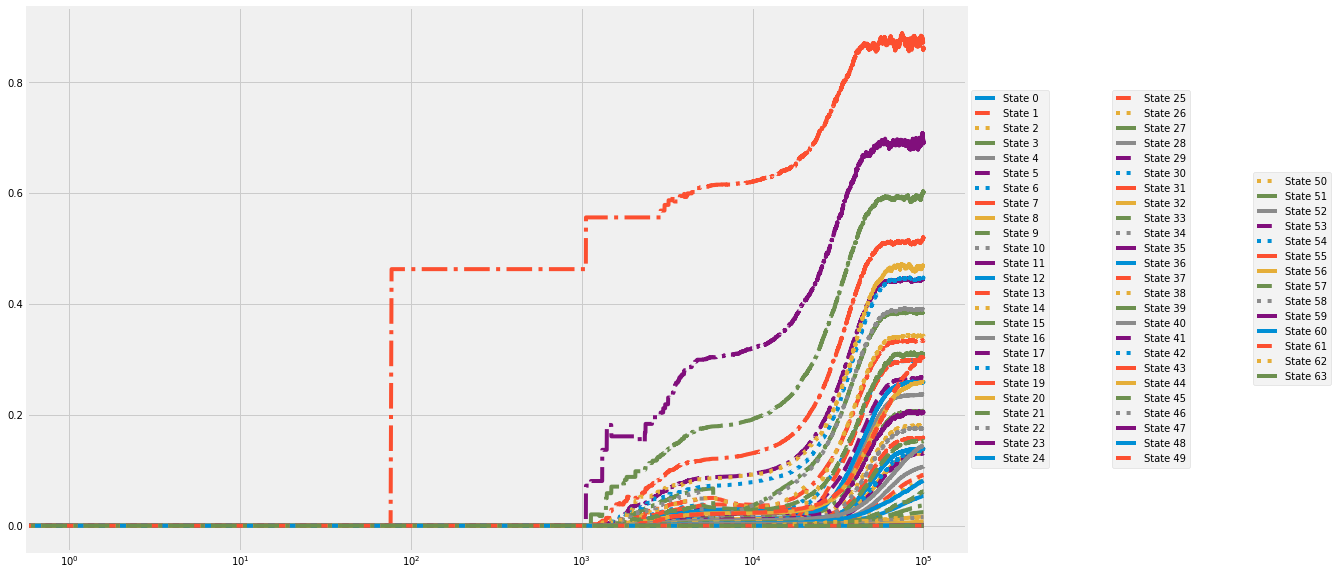

In [46]:
plot_value_function(np.max(Q_track, axis=2), True)

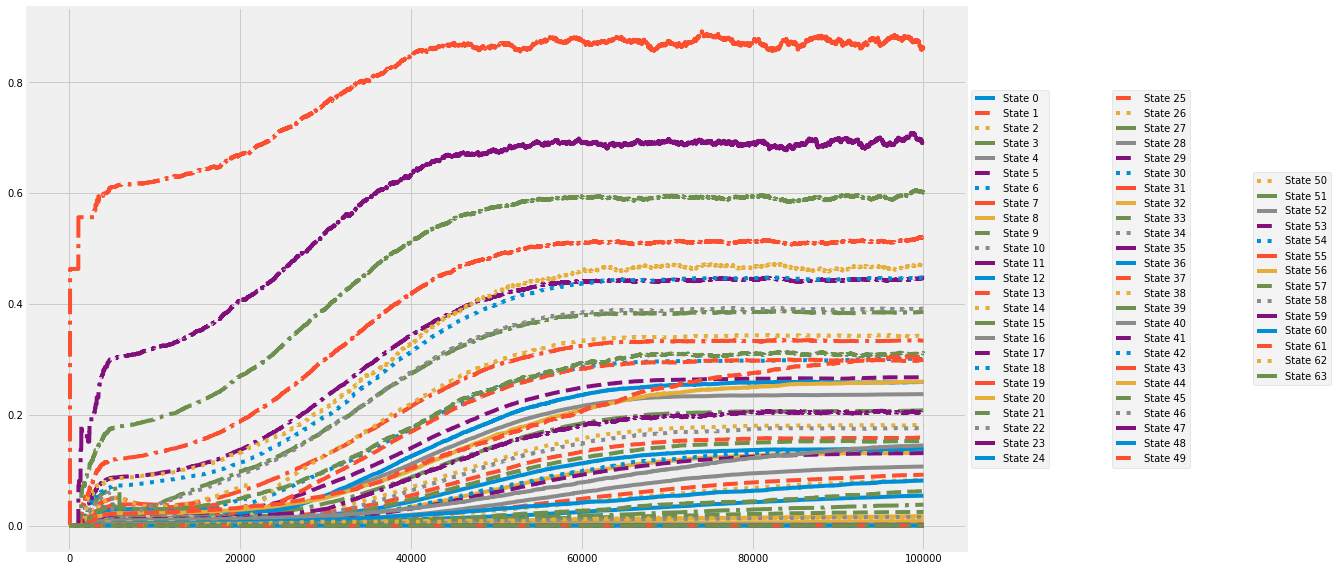

In [47]:
plot_value_function(np.max(Q_track, axis=2))

Now, we introduce Watkins Q(Lambda).

In [48]:
def q_lambda(env,
             gamma = 0.9,
             lambda_ = 0.5,
             initial_alpha = 0.5,
             alpha_decay_rate = 1e-3,
             min_alpha = 0.001,
             initial_epsilon = 1.,
             epsilon_decay_rate = 1e-5,
             min_epsilon = 0.0,
             n_episodes=100000):
    nS, nA = env.observation_space.n, env.action_space.n
    Q = np.zeros((nS, nA))
    E = np.zeros((nS, nA))
    Q_track = np.zeros((n_episodes, nS, nA))
    select_action = lambda state, Q, epsilon: np.argmax(Q[state]) \
        if np.random.random() > epsilon \
        else np.random.randint(nA)
    
    for t in tqdm(range(n_episodes)):
        alpha = max(initial_alpha * np.exp(-alpha_decay_rate * t), min_alpha)
        epsilon = max(initial_epsilon * np.exp(-epsilon_decay_rate * t), min_epsilon)
        E.fill(0)
        
        state, done = env.reset(), False
        while not done:
            action = select_action(state, Q, epsilon)
            new_state, reward, done, _ = env.step(action)
            new_action = select_action(new_state, Q, epsilon)
            
            best_new_action = np.argmax(Q[new_state])
            if np.allclose(Q[new_state][new_action], Q[new_state][best_new_action]):
                best_new_action = new_action

            if done:
                Q[new_state] = 0.
                Q_est = reward
            else: 
                Q_est = reward + gamma * Q[new_state].max()

            E[state][action] = E[state][action] + 1
            Q = Q + alpha * (Q_est - Q[state][action]) * E

            if new_action == best_new_action:
                E = gamma * lambda_ * E
            else:
                E.fill(0)

            state, action = new_state, new_action
            
        Q_track[t] = Q

    pi = {s:a for s, a in enumerate(np.argmax(Q, axis=1))}
    V = np.max(Q, axis=1)
    return Q, V, pi, Q_track


Q_best, V_best, pi_best, Q_track = q_lambda(env)
Q_best, V_best, pi_best

100%|██████████| 100000/100000 [02:58<00:00, 558.76it/s]


(array([[ 0.12756753,  0.12738333,  0.14201971,  0.12973315],
        [ 0.13153617,  0.14371666,  0.16175913,  0.14695791],
        [ 0.149909  ,  0.16448064,  0.18493114,  0.16725056],
        [ 0.1716041 ,  0.19082465,  0.21103767,  0.19079853],
        [ 0.19914041,  0.23396027,  0.24007436,  0.21791315],
        [ 0.22538889,  0.26816738,  0.27036536,  0.24516133],
        [ 0.25377457,  0.30396815,  0.3036272 ,  0.27452695],
        [ 0.28370367,  0.33835362,  0.3102148 ,  0.30185455],
        [ 0.12355191,  0.11601424,  0.13836198,  0.12847437],
        [ 0.12781391,  0.13105876,  0.15748636,  0.14644014],
        [ 0.14417475,  0.13956914,  0.1803716 ,  0.16702286],
        [ 0.15068046,  0.04044947,  0.20663403,  0.19289234],
        [ 0.19671811,  0.23959917,  0.26263151,  0.22045974],
        [ 0.24319147,  0.28258723,  0.30032084,  0.25190856],
        [ 0.28214852,  0.34438335,  0.34331826,  0.28295446],
        [ 0.32265444,  0.38612684,  0.35343118,  0.31174693],
        

In [49]:
probability_success(env, pi_best)

73.359999999999999

In [50]:
print_policy(pi_best, env.env.P)

| 00 > | 01 > | 02 > | 03 > | 04 > | 05 > | 06 v | 07 v |
| 08 > | 09 > | 10 > | 11 > | 12 > | 13 > | 14 v | 15 v |
| 16 ^ | 17 ^ | 18 ^ |      | 20 > | 21 > | 22 v | 23 v |
| 24 > | 25 ^ | 26 ^ | 27 > | 28 ^ |      | 30 > | 31 v |
| 32 > | 33 ^ | 34 ^ |      | 36 ^ | 37 > | 38 > | 39 v |
| 40 ^ |      |      | 43 > | 44 ^ | 45 ^ |      | 47 v |
| 48 ^ |      | 50 v | 51 ^ |      | 53 ^ |      | 55 v |
| 56 ^ | 57 < | 58 < |      | 60 < | 61 > | 62 > |      |


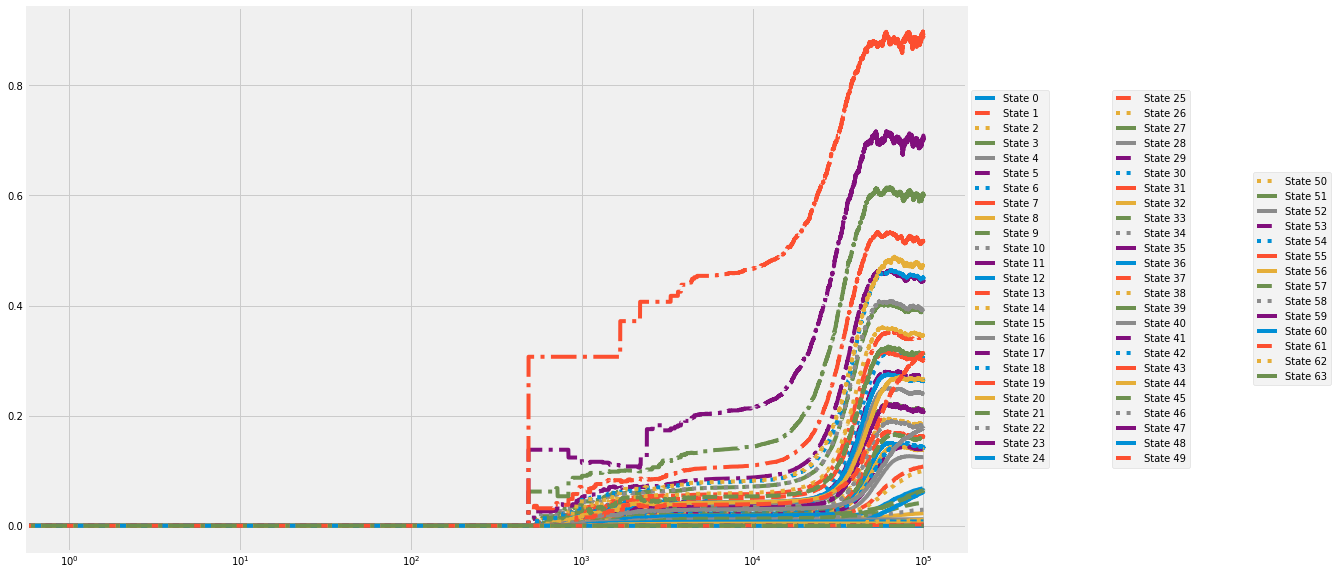

In [51]:
plot_value_function(np.max(Q_track, axis=2), True)

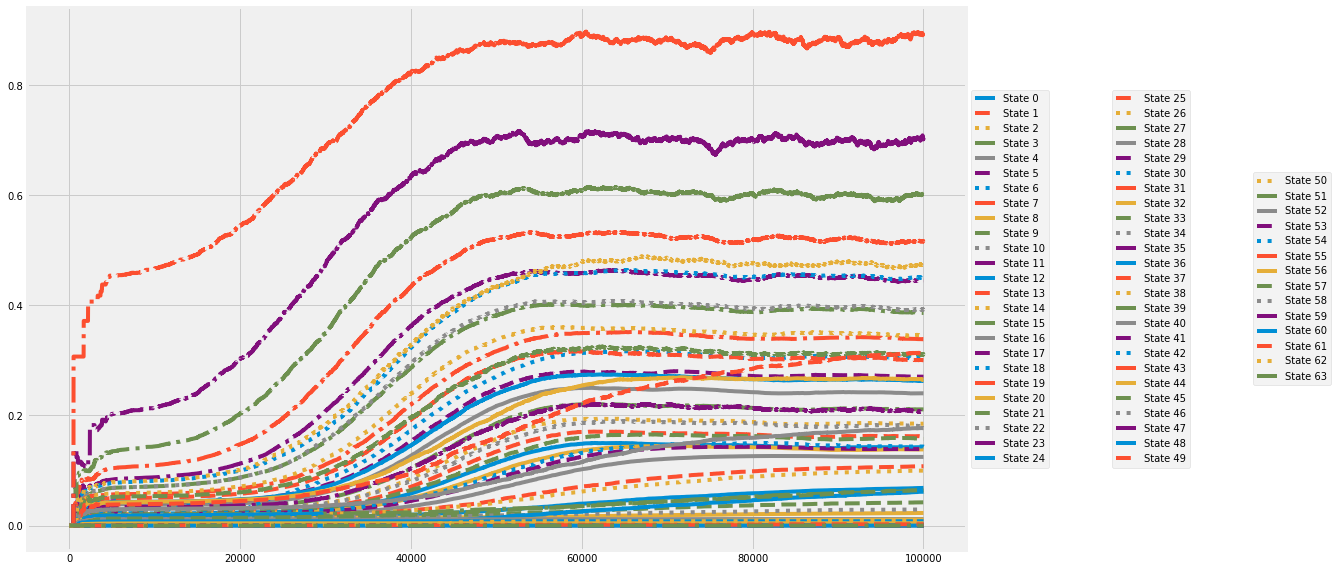

In [52]:
plot_value_function(np.max(Q_track, axis=2))

Just as before, we can zoom-in and peek into the way the values get updated.

100%|██████████| 1000/1000 [00:00<00:00, 1823.19it/s]


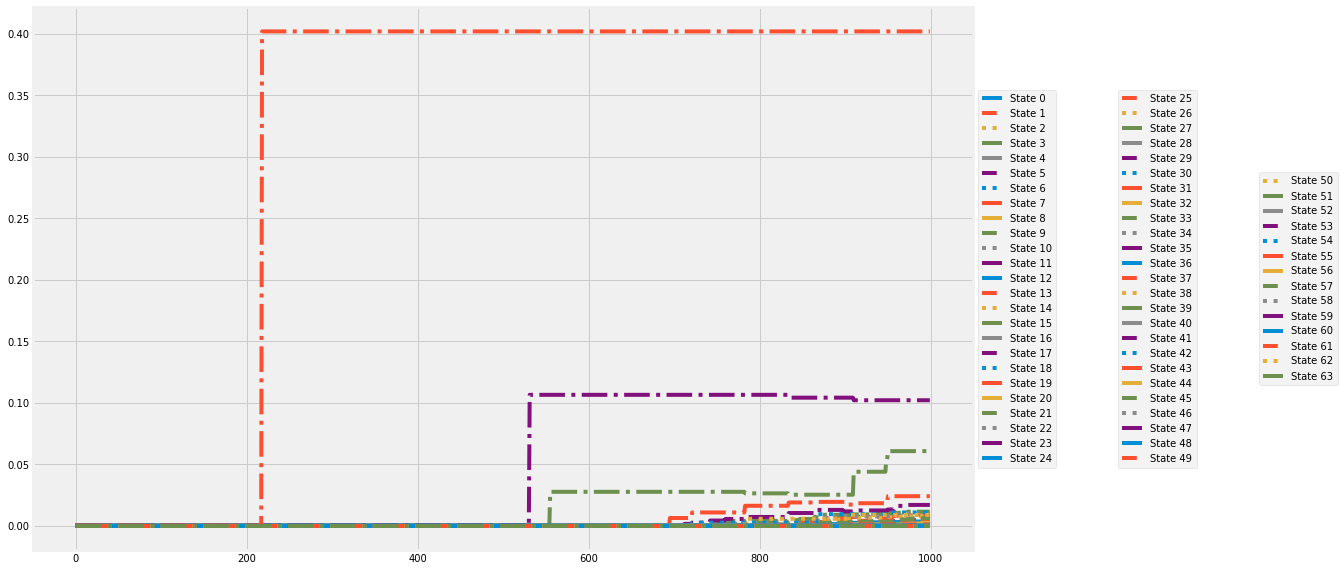

In [53]:
Q_best, V_best, pi_best, Q_track = q_learning(env, n_episodes=1000)
plot_value_function(np.max(Q_track, axis=2))

100%|██████████| 1000/1000 [00:01<00:00, 500.42it/s]


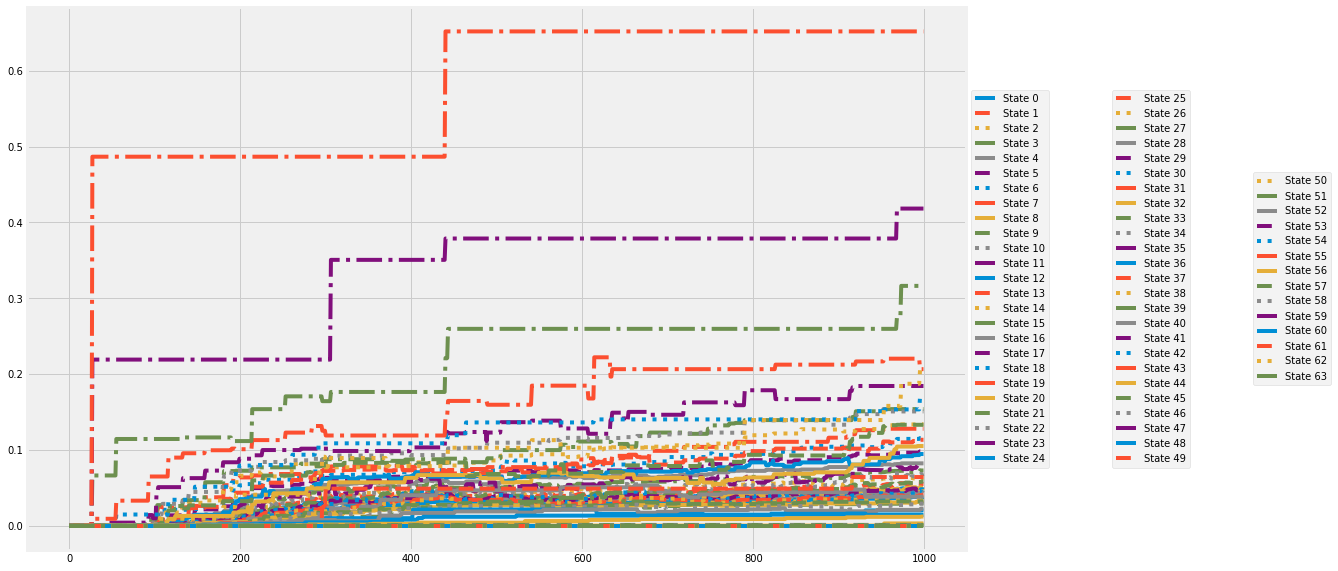

In [54]:
Q_best, V_best, pi_best, Q_track = q_lambda(env, n_episodes=1000)
plot_value_function(np.max(Q_track, axis=2))

We know implement a simple Dyna-Q agent.

In [74]:
def dyna_q(env,
           gamma = 0.9,
           initial_alpha = 0.5,
           alpha_decay_rate = 1e-3,
           min_alpha = 0.01,
           initial_epsilon = 1.,
           epsilon_decay_rate = 1e-4,
           min_epsilon = 0.01,
           n_planning=20,
           n_episodes=5000):

    nS, nA = env.observation_space.n, env.action_space.n
    Q = np.zeros((nS, nA))
    T_count = np.zeros((nS, nA, nS))
    R_model = np.zeros((nS, nA, nS))

    Q_track = np.zeros((n_episodes, nS, nA))
    select_action = lambda state, Q, epsilon: np.argmax(Q[state]) \
        if np.random.random() > epsilon \
        else np.random.randint(nA)
    
    for t in tqdm(range(n_episodes)):
        alpha = max(initial_alpha * np.exp(-alpha_decay_rate * t), min_alpha)
        epsilon = max(initial_epsilon * np.exp(-epsilon_decay_rate * t), min_epsilon)

        state, done = env.reset(), False
        while not done:
            action = select_action(state, Q, epsilon)
            new_state, reward, done, _ = env.step(action)
            
            T_count[state][action][new_state] += 1
            r_diff = reward - R_model[state][action][new_state]
            R_model[state][action][new_state] += r_diff / T_count[state][action][new_state]

            if done:
                Q[new_state] = 0.
                Q_est = reward
            else: 
                Q_est = reward + gamma * Q[new_state].max()
            Q[state][action] = Q[state][action] + alpha * (Q_est - Q[state][action])

            backup_new_state = new_state
            for _ in range(n_planning):
                if Q.sum() == 0:
                    break

                visited_states = np.where(np.sum(T_count, axis=(1,2)) > 0)[0]
                state = np.random.choice(visited_states)
                
                actions_taken = np.where(np.sum(T_count[state], axis=1) > 0)[0]
                action = np.random.choice(actions_taken)

                probs = T_count[state][action]/T_count[state][action].sum()
                new_state = np.random.choice(np.arange(len(T_count[state][action])), 
                                             size=1, p=probs)[0]
                reward = R_model[state][action][new_state]
                    
                Q_est = reward + gamma * Q[new_state].max()
                Q[state][action] = Q[state][action] + alpha * (Q_est - Q[state][action])
            state = backup_new_state
        Q_track[t] = Q

    pi = {s:a for s, a in enumerate(np.argmax(Q, axis=1))}
    V = np.max(Q, axis=1)
    return Q, V, pi, Q_track

Q_best, V_best, pi_best, Q_track = dyna_q(env)
Q_best, V_best, pi_best

100%|██████████| 5000/5000 [03:22<00:00, 24.69it/s] 


(array([[ 0.12687617,  0.12564508,  0.14091971,  0.12962637],
        [ 0.13024284,  0.14095932,  0.16107966,  0.14610095],
        [ 0.14970386,  0.16008354,  0.18368819,  0.16706312],
        [ 0.16997128,  0.18301514,  0.21093952,  0.18978834],
        [ 0.19602659,  0.23277157,  0.23940541,  0.21553734],
        [ 0.22187787,  0.26500318,  0.26768294,  0.24175733],
        [ 0.25351841,  0.2999032 ,  0.298731  ,  0.27158479],
        [ 0.28129582,  0.3338484 ,  0.30470025,  0.29717163],
        [ 0.12118048,  0.1141834 ,  0.13386281,  0.12829389],
        [ 0.12403734,  0.12728056,  0.15355949,  0.14523592],
        [ 0.13984631,  0.13107512,  0.1750675 ,  0.16496652],
        [ 0.15089696,  0.03476965,  0.20146896,  0.19016182],
        [ 0.18861534,  0.24263703,  0.26306112,  0.21764025],
        [ 0.24036329,  0.27689697,  0.3016084 ,  0.24900835],
        [ 0.28139342,  0.34475652,  0.3428164 ,  0.27973058],
        [ 0.32197456,  0.39197105,  0.34679617,  0.30601467],
        

In [75]:
probability_success(env, pi_best)

72.519999999999996

In [76]:
print_policy(pi_best, env.env.P)

| 00 > | 01 > | 02 > | 03 > | 04 > | 05 > | 06 v | 07 v |
| 08 > | 09 > | 10 > | 11 > | 12 > | 13 > | 14 v | 15 v |
| 16 > | 17 ^ | 18 ^ |      | 20 > | 21 > | 22 v | 23 v |
| 24 > | 25 > | 26 > | 27 > | 28 v |      | 30 > | 31 v |
| 32 ^ | 33 ^ | 34 ^ |      | 36 > | 37 > | 38 > | 39 v |
| 40 ^ |      |      | 43 > | 44 ^ | 45 v |      | 47 v |
| 48 ^ |      | 50 v | 51 ^ |      | 53 v |      | 55 v |
| 56 ^ | 57 < | 58 < |      | 60 < | 61 > | 62 ^ |      |


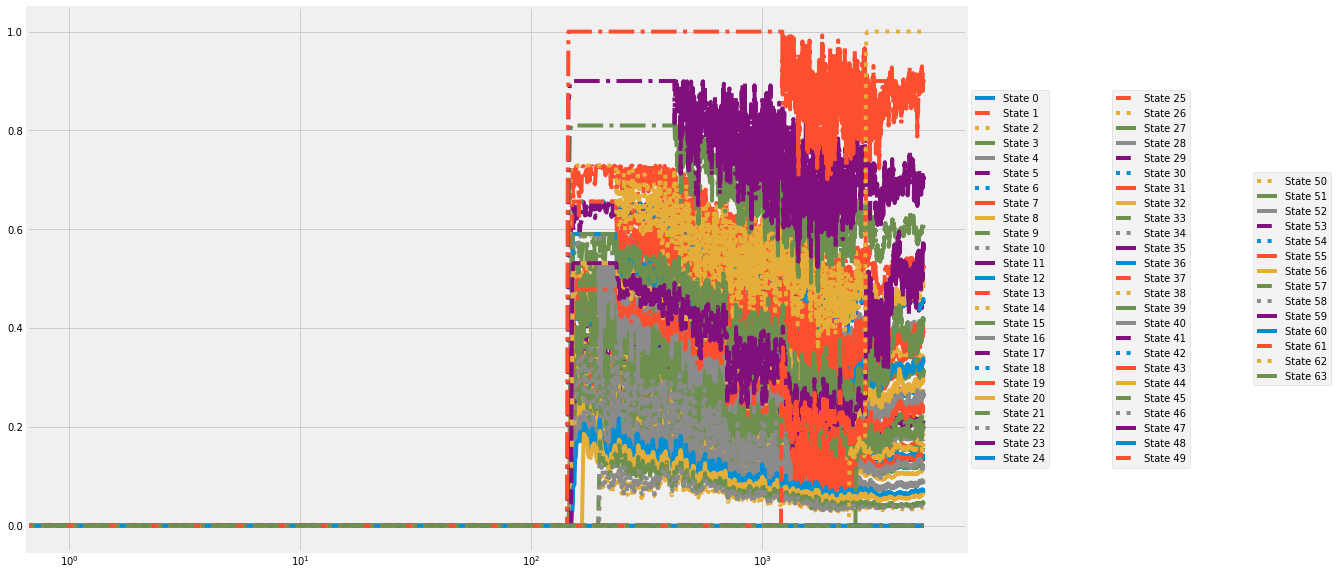

In [77]:
plot_value_function(np.max(Q_track, axis=2), True)

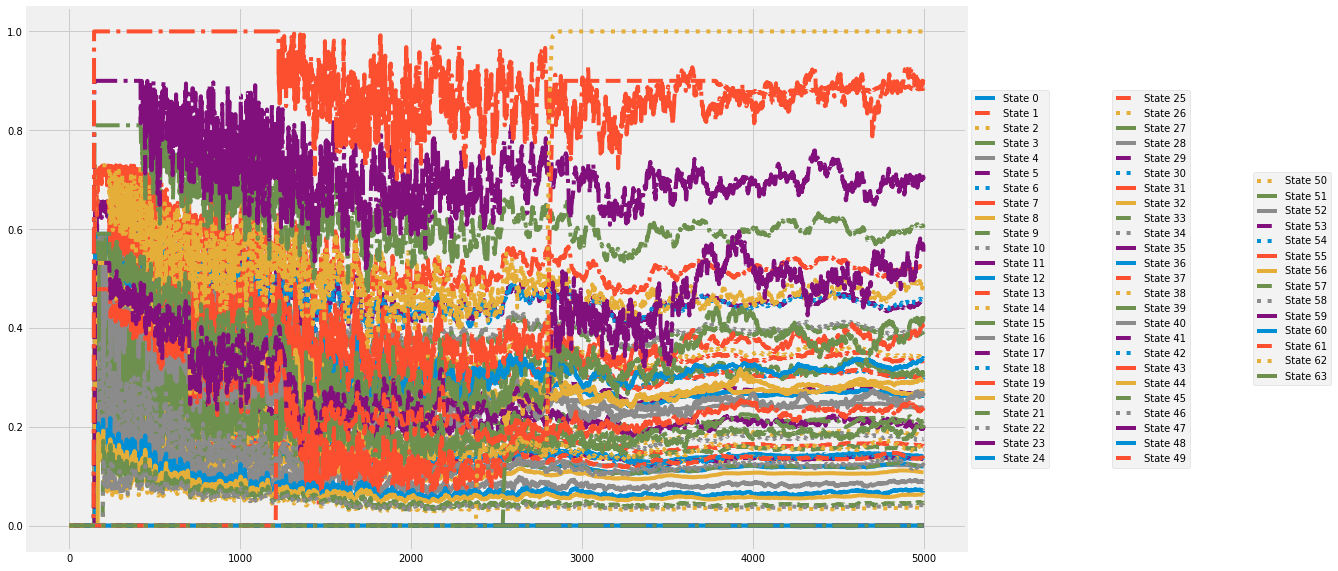

In [78]:
plot_value_function(np.max(Q_track, axis=2))

100%|██████████| 1000/1000 [00:22<00:00, 44.95it/s] 


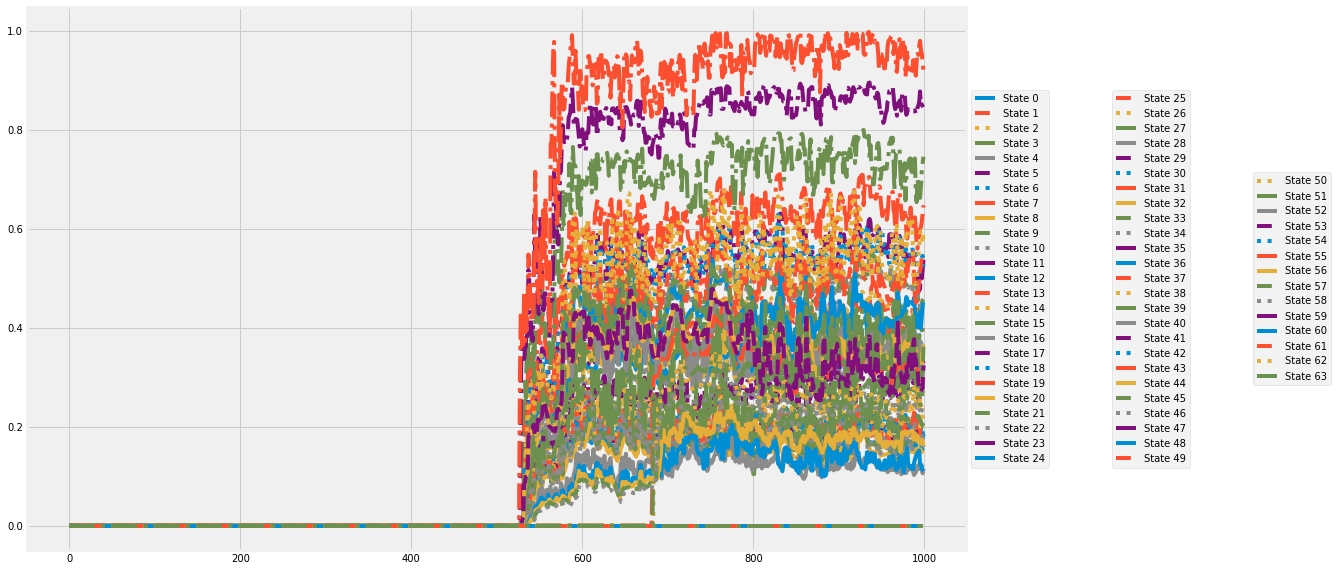

In [84]:
Q_best, V_best, pi_best, Q_track = dyna_q(env, n_episodes=1000)
plot_value_function(np.max(Q_track, axis=2))

See how quickly after the first non-zero reward is encounter the value functions rise? They get updated by the planning method. The model-learning step is learning the model even when the model hasn't encountered a reward. As soon as the first reward is encountered the values start propagating very quickly.